In [47]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

# 正解データのリサイズ

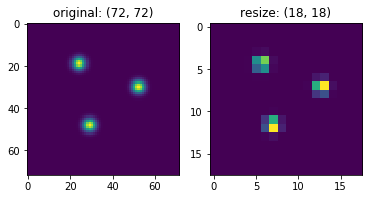

In [73]:
# 正解の密度マップ(1 channel)をリサイズする
# 72x72 -> 18x18
answerDens = np.load("../data/dens/196.npy")
answerDens = answerDens[288:,568:]
plt.subplot(1, 2, 1)
plt.title("original: {}".format(answerDens.shape))
plt.imshow(answerDens)

reAnswerDens = cv2.resize(answerDens, (18, 18), cv2.INTER_LINEAR)
plt.subplot(1, 2, 2)
plt.title("resize: {}".format(reAnswerDens.shape))
plt.imshow(reAnswerDens)

# CNN

In [18]:
# 変数定義
sess = tf.Session()
sess.run(tf.global_variables_initializer())

dim = 72*72*3
with tf.name_scope("X"):
    x = tf.placeholder(tf.float32, [None, dim])
    
with tf.name_scope("W"):
    w = tf.Variable(tf.zeros([dim, 1]))
    
with tf.name_scope("multi"):
    y = tf.matmul(x, w)
    
with tf.name_scope("T"):
    t = tf.placeholder(tf.float32, [None, 1])
    

In [19]:
# 重みを標準偏差0.1の正規分布で初期化
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

In [20]:
# バイアスを標準偏差0.1の正規分布で初期化
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [37]:
# 畳み込み層
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding="SAME")

In [22]:
# プーリング層
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

In [23]:
# 第一層
# convlution -> ReLU -> max pooling
# input 72x72x3 -> output 36x36x32

# 7x7x3 filter
with tf.name_scope("conv1"):
    W_conv1 = weight_variable([7,7,3,32])
    b_conv1 = bias_variable([32])
    x_image = tf.reshape(x, [-1, 72, 72, 3])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

with tf.name_scope("pool1"):
    h_pool1 = max_pool_2x2(h_conv1)

In [24]:
# 第二層
# convlution -> ReLU -> max pooling
# input 36x36x32 -> output 18x18x32

# 7x7x32 filter
with tf.name_scope("conv2"):
    W_conv2 = weight_variable([7,7,32,32])
    b_conv2 = bias_variable([32])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    
with tf.name_scope("pool2"):
    h_pool2 = max_pool_2x2(h_conv2)

In [25]:
# 第三層
# convolution -> ReLU
# input 18x18x32 -> output 18x18x64

# 5x5x32 filter
with tf.name_scope("conv3"):
    W_conv3 = weight_variable([5,5,32,64])
    b_conv3 = bias_variable([64])
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)

In [26]:
# 第四層
# fully connected layer
# input 18x18x64 -> output 1000

with tf.name_scope("fc4"):
    W_fc4 = weight_variable([18*18*64, 1000])
    b_fc4 = bias_variable([1000])
    h_conv3_flat = tf.reshape(h_conv3, [-1, 18*18*64])
    h_fc4 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc4) + b_fc4)

In [27]:
# 第五層
# fully connected layer
# input 1000 -> output 400

with tf.name_scope("fc5"):
    W_fc5 = weight_variable([1000, 400])
    b_fc5 = bias_variable([400])
    h_fc5 = tf.nn.relu(tf.matmul(h_fc4, W_fc5) + b_fc5)

In [35]:
# 第六層
# fully connected layer
# input 400 -> output 324

with tf.name_scope("fc6"):
    W_fc6 = weight_variable([400, 324])
    b_fc6 = bias_variable([324])
    h_fc6 = tf.nn.relu(tf.matmul(h_fc5, W_fc6) + b_fc6) 

In [36]:
# 画像の形にリサイズ(18x18)
output = tf.reshape(h_fc6, [18, 18])